In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np


data_dir = 'flowers/'

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Изменение размера изображений
    transforms.ToTensor(),         # Конвертация в тензор
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация
])

dataset = ImageFolder(root=data_dir, transform=transform)

Загружаем изображения с помощью PyTorch. Нормализуем значения RGB в пикселях. Изоюражения приаодим к размеру 128 на 128 пикселей.

In [ ]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

Данные корректно считались с метками классов. Всего классов 5.

In [ ]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.7 * len(dataset))  # 70% данных для тренировки
val_size = int(0.2 * len(dataset))    # 20% данных для валидации
test_size = len(dataset) - train_size - val_size  # Оставшиеся 10% для теста

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Разделяем данные на тренировочную, валидационную и тестовую выборки. Распределение получилось 70:20:10. Также данные будут обрабатываться батчами(пакетами), поэтому создаем loader'ы для каждой из выборок.

In [ ]:
from torchsummary import summary
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # Сверточные слои
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        #self.conv11 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        #self.conv22 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        #self.conv33 = nn.Conv2d(128, 128, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        #self.conv44 = nn.Conv2d(256, 256, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        # Полносвязные слои
        self.fc1 = nn.Linear(256 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)



        x = x.view(-1, 256 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

num_classes = 5
model = CNN(num_classes)

summary(model,(3,128,128))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
              ReLU-8          [-1, 128, 32, 32]               0
         MaxPool2d-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 256, 16, 16]         295,168
             ReLU-11          [-1, 256, 16, 16]               0
        MaxPool2d-12            [-1, 256, 8, 8]               0
           Linear-13                  [-1, 256]       4,194,560
          Dropout-14                  [

Строим Свёрточную Нейронную сеть. Она состоит из чередования 4 сверточных слоёв и 4 слоёв субдискретизации. Далее данные преобразуются в вектор длины 256, проходят через слой регуляризации для предотвращения переобучения. Последний полносвязный слой выводит вероятности для 5 классов.

В качестве функции потерь используется перекрестная энтропия. В качестве оптимизатора используется Adam со скоростью обучения lr=0.0005 и параметром L2-регуляризации weight_decay=1e-4

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 50
l1_lambda = 1e-4
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    # Обучение
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        l1_loss = 0.0
        for param in model.parameters():
            l1_loss += torch.norm(param, p=1)  # L1 norm

        loss += l1_lambda * l1_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Валидация
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)




    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f} "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")




Epoch 1/50, Train Loss: 3.7655 Val Loss: 1.1796, Val Accuracy: 49.83%
Epoch 2/50, Train Loss: 1.6600 Val Loss: 1.0827, Val Accuracy: 57.24%
Epoch 3/50, Train Loss: 1.5441 Val Loss: 1.0149, Val Accuracy: 60.95%
Epoch 4/50, Train Loss: 1.4361 Val Loss: 1.0207, Val Accuracy: 58.75%
Epoch 5/50, Train Loss: 1.3925 Val Loss: 0.9794, Val Accuracy: 61.99%
Epoch 6/50, Train Loss: 1.3556 Val Loss: 0.9180, Val Accuracy: 63.85%
Epoch 7/50, Train Loss: 1.3081 Val Loss: 0.8897, Val Accuracy: 64.77%
Epoch 8/50, Train Loss: 1.2605 Val Loss: 0.9050, Val Accuracy: 63.04%
Epoch 9/50, Train Loss: 1.2485 Val Loss: 0.8724, Val Accuracy: 64.66%
Epoch 10/50, Train Loss: 1.2381 Val Loss: 0.8998, Val Accuracy: 63.73%
Epoch 11/50, Train Loss: 1.2076 Val Loss: 0.8733, Val Accuracy: 64.08%
Epoch 12/50, Train Loss: 1.1971 Val Loss: 0.8475, Val Accuracy: 66.63%
Epoch 13/50, Train Loss: 1.1693 Val Loss: 0.8148, Val Accuracy: 67.44%
Epoch 14/50, Train Loss: 1.1170 Val Loss: 0.8372, Val Accuracy: 68.13%
Epoch 15/50, Tr

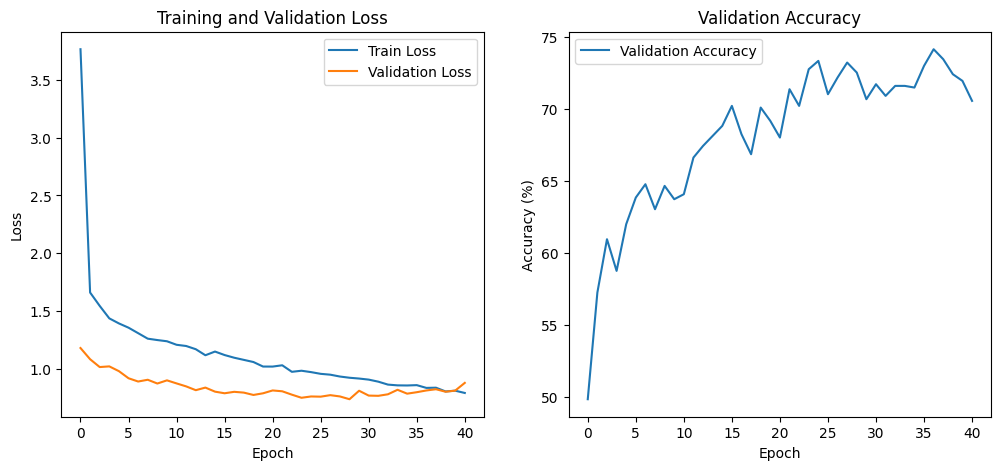

In [ ]:
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()

plt.show()

In [ ]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 1.0372, Test Accuracy: 66.97%


По результатам видно, что при обучении функция потерь постепенно снижается для тренировончной выборки и для валидационной, но для валидационной снижение очень медленное.
Accuracy на валидационной выборке постепенно увеличивается, но где-то к 30 эпохе развитие почти не растет.

На тестовой выборке Accuracy: 66.97%, что в целом приемлевый результат, но ещё есть что улучшать.

In [ ]:
torch.save(model.state_dict(), "flower_cnn.pth")

In [ ]:
# Определение автокодировщика
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Кодировщик
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 128 * 3, 512),
            nn.ReLU(True),
            nn.Linear(512, 128),
            nn.ReLU(True),
            nn.Linear(128, 16),
        )
        # Декодировщик
        self.decoder = nn.Sequential(
            nn.Linear(16, 128),
            nn.ReLU(True),
            nn.Linear(128, 512),
            nn.ReLU(True),
            nn.Linear(512, 128 * 128 * 3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Инициализация модели
autoencoder = Autoencoder()
summary(autoencoder,(3,128,128))
# Оптимизатор и функция потерь
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.MSELoss()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 49152]               0
            Linear-2                  [-1, 512]      25,166,336
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 128]          65,664
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 16]           2,064
            Linear-7                  [-1, 128]           2,176
              ReLU-8                  [-1, 128]               0
            Linear-9                  [-1, 512]          66,048
             ReLU-10                  [-1, 512]               0
           Linear-11                [-1, 49152]      25,214,976
             Tanh-12                [-1, 49152]               0
Total params: 50,517,264
Trainable params: 50,517,264
Non-trainable params: 0
-------------------------

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)  # Разворачиваем изображения
        output = autoencoder(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.2874
Epoch [2/10], Loss: 0.2277
Epoch [3/10], Loss: 0.1462
Epoch [4/10], Loss: 0.1521
Epoch [5/10], Loss: 0.1382
Epoch [6/10], Loss: 0.1371
Epoch [7/10], Loss: 0.1642
Epoch [8/10], Loss: 0.1565
Epoch [9/10], Loss: 0.1403
Epoch [10/10], Loss: 0.1156


In [ ]:
class FlowerClassifier(nn.Module):
    def __init__(self, pretrained_encoder):
        super(FlowerClassifier, self).__init__()
        self.encoder = pretrained_encoder  # Загружаем кодировщик
        self.classifier = nn.Sequential(
            nn.Linear(16, 128),  # Используем выход из кодировщика
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 5),  # 5 классов
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Разворачиваем изображения
        x = self.encoder(x)        # Используем кодировщик
        x = self.classifier(x)
        return x

# Инициализация классификатора с предобученным кодировщиком
classifier = FlowerClassifier(autoencoder.encoder)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4,weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
fn_l1_lambda = 1e-4

In [ ]:
num_epochs = 20
fn_train_losses, fn_val_losses, fn_train_accuracies, fn_val_accuracies = [], [], [], []
for epoch in range(num_epochs):
    classifier.train()
    train_loss = 0

    for data in train_loader:
        images, labels = data
        outputs = classifier(images)
        loss = criterion(outputs, labels)

        l1_loss = 0.0
        for param in model.parameters():
            l1_loss += torch.norm(param, p=1)  # L1 norm

        loss += fn_l1_lambda * l1_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    fn_train_losses.append(train_loss / len(train_loader))
    # Валидация
    classifier.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = classifier(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    fn_val_losses.append(val_loss / len(val_loader))
    fn_val_accuracies.append(100 * correct / total)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss/len(train_loader):.4f}, '
          f'Val Loss: {val_loss/len(val_loader):.4f}, '
          f'Val Accuracy: {100 * correct / total:.2f}%')


Epoch [1/20], Train Loss: 2.1172, Val Loss: 1.4225, Val Accuracy: 39.28%
Epoch [2/20], Train Loss: 1.7894, Val Loss: 1.2868, Val Accuracy: 47.05%
Epoch [3/20], Train Loss: 1.6766, Val Loss: 1.2423, Val Accuracy: 47.74%
Epoch [4/20], Train Loss: 1.5901, Val Loss: 1.2044, Val Accuracy: 50.52%
Epoch [5/20], Train Loss: 1.5258, Val Loss: 1.2069, Val Accuracy: 50.06%
Epoch [6/20], Train Loss: 1.4236, Val Loss: 1.2360, Val Accuracy: 46.93%
Epoch [7/20], Train Loss: 1.3607, Val Loss: 1.1968, Val Accuracy: 51.45%
Epoch [8/20], Train Loss: 1.2505, Val Loss: 1.2115, Val Accuracy: 50.41%
Epoch [9/20], Train Loss: 1.1534, Val Loss: 1.2101, Val Accuracy: 49.59%
Epoch [10/20], Train Loss: 1.0686, Val Loss: 1.2613, Val Accuracy: 50.17%
Epoch [11/20], Train Loss: 0.9325, Val Loss: 1.3311, Val Accuracy: 49.36%
Epoch [12/20], Train Loss: 0.8614, Val Loss: 1.4035, Val Accuracy: 49.02%
Epoch [13/20], Train Loss: 0.7980, Val Loss: 1.4382, Val Accuracy: 48.67%
Epoch [14/20], Train Loss: 0.7265, Val Loss: 1.

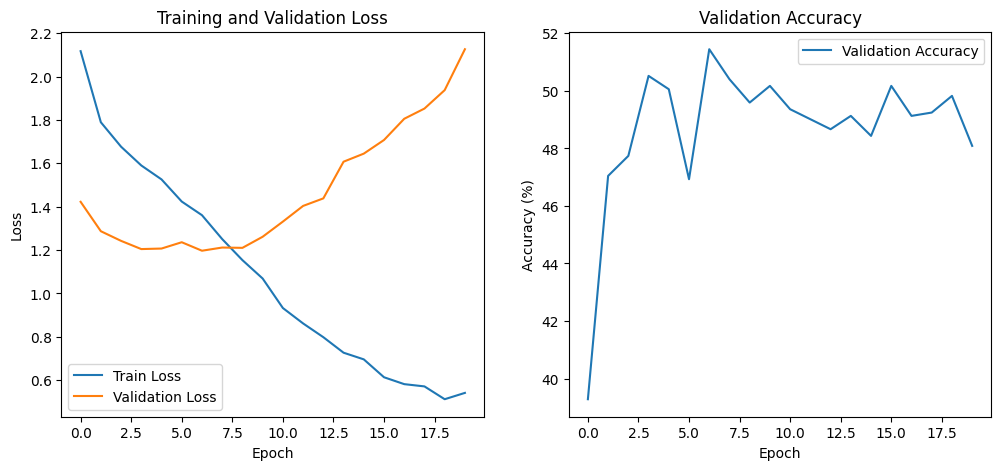

In [ ]:
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(fn_train_losses, label="Train Loss")
plt.plot(fn_val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(fn_val_accuracies, label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()

plt.show()

In [ ]:
classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = classifier(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 43.19%


In [ ]:
torch.save(classifier.state_dict(), "flower_fullnn.pth")

По графикам видно, что модель быстро переобучается и результаты становятся относительно плохие. Accuracy почти сразу перестает расти и даже ухудшаться. На тестовой выборке резульатат можно оценивать как плохой.

## Выводы
Сравнили две модели для задачи классификации изображений цветов: сверточная нейронна сеть и предобученная полносвязная нейронная сеть. Всего классов 5.

Для сверточной модели результаты:
Test Accuracy: 66.97%

Для полносвязной модели результаты:
Test Accuracy: 43.19%

Сверточная модель показала лучшие результаты как на валидационной, так и на тестовой выборках. Полносвязная модель быстро переобучается и показывает относительно плохие результаты в предсказаниях.